# Analysis of Reaction Times

## Objective
The goal is not only to perform behavioral analysis, but also to understand the data better.

---

## Notebook Workflow

### 1. Load and Preprocess Data
- Compute `reaction_time` = `time_targ_acq - time_FP_off`
- Compute `go_time` = `time_FP_off - time_target_on`
- Filter trials with valid timestamps

### 2. Visualize Reaction Times
- Plot **reaction time vs go_time** for both sessions
- Overlay smoothed RT curves using Gaussian filtering
- Annotate the ketamine **onset and wash-off points** based on data-driven detection

### 3. Compare RT Distributions
- Use KDE plots to compare the full distribution of RTs
- Statistical t-test for mean RT difference
- Compare trial-to-trial variability

### 4. Fit Reaction Time Models
- Fit **Weibull-based subjective hazard functions** to both sessions:
- Plot:
    - Smoothed RT (purple line)
    - Fitted anticipation curve (black)
    - Dashed purple curve = subjective hazard function

### 5. Identify Ketamine Phases (Onset, Active, Wash-off)
- Use gradients of smoothed RT to **detect change-points**
- Segment trials by `go_time`:
    - **Pre-Ketamine Phase**
    - **Ketamine Active Phase**
    - **Wash-Off Phase**
- Plot RT over `go_time` with shaded regions for interpretation

---

## Theoretical Understanding

- **Ketamine disrupts internal timing**: Under NMDA receptor blockade, the brain cannot generate or maintain the **subjective anticipation function** (hazard rate).
- **Decreased anticipation gain** and **delayed RT response** reflect impaired neural integration of elapsed time.
- **Temporal ramping signals** in PFC/LIP are likely disrupted, leading to noisier and less precise action planning.
- The **recovery** of behavior after `go_time ≈ 1.75s` supports that ketamine has a short half-life.

---

## Summary

This analysis combines:
- Behavioral measurements
- Statistical testing
- Subjective hazard modeling (computational timing)
- Phase segmentation based on RT changes

In [1]:
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
file_path = '20140925_Ketamine02/Charlie_20140925_master_AnticipSacc_behavior.mat'
data = loadmat(file_path)

print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'eMat'])


In [2]:
file_path_ = 'timeData.mat/timeData.mat'
columns = loadmat(file_path_)
columnnames = columns['columnNames']

In [3]:
data['eMat'].shape

(953, 42)

In [4]:
df_n = pd.read_csv("Sample_200.csv")

In [5]:
column_names = [name for name in columns['columnNames'].dtype.names]
trial_data = data['eMat']
df = pd.DataFrame(trial_data, columns=column_names[:trial_data.shape[1]])

In [6]:
df.dropna(axis=1, how='all')

,monkeyID,fileID,trial_type,target1_x,target1_y,dot_duration,fixation_x,fixation_y,time_FP_on,time_target_on,time_target_off,time_FP_off,time_targ_acq,time_reward,time_end
0,2097.0,1001.0,19.0,9.51296,5.48394,1413.333333,0.0,0.0,62.709800,63.377350,63.671000,NaN,NaN,NaN,NaN
1,2097.0,1002.0,19.0,9.51296,-5.48394,733.333333,0.0,0.0,67.742525,68.424200,68.717200,69.491325,69.865175,69.985225,70.078700
2,2097.0,1003.0,19.0,11.00520,0.00000,1560.000000,0.0,0.0,71.240075,71.867675,72.161350,NaN,NaN,NaN,NaN
3,2097.0,1004.0,19.0,11.00520,0.00000,NaN,0.0,0.0,76.900300,77.661275,NaN,NaN,NaN,NaN,NaN
4,2097.0,1005.0,19.0,9.51296,5.48394,1306.666667,0.0,0.0,79.062975,79.783875,80.077525,81.425825,81.826275,81.946425,82.039900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,2097.0,3224.0,19.0,9.51296,5.48394,1253.333333,0.0,0.0,3915.762350,3917.003800,3917.297575,3918.592475,3918.952875,3919.072950,3919.166475
949,2097.0,3225.0,19.0,11.00520,0.00000,973.333333,0.0,0.0,3920.327850,3921.035425,3921.329075,3922.343675,3922.690725,3922.810825,3922.904275
950,2097.0,3226.0,19.0,11.00520,0.00000,880.000000,0.0,0.0,3924.065700,3924.973525,3925.267200,3926.188275,3926.548725,3926.668900,3926.762350
951,2097.0,3227.0,19.0,5.52125,9.51296,906.666667,0.0,0.0,3927.923725,3928.938275,3929.232075,NaN,NaN,NaN,NaN


In [7]:
df["reaction_time"] = df["time_targ_acq"] - df["time_FP_off"]
df["go_time"] = df["time_FP_off"] - df["time_target_on"]

In [8]:
df = df[df["reaction_time"].notna() & df["go_time"].notna()]

In [9]:
df_n = df_n[df_n["reaction_time"].notna() & df_n["go_time"].notna()]

In [10]:
df_n.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            151, 152, 153, 154, 155, 156, 157, 158, 159, 160],
           dtype='int64', length=161)

In [11]:
df.reset_index(drop=True, inplace=True)

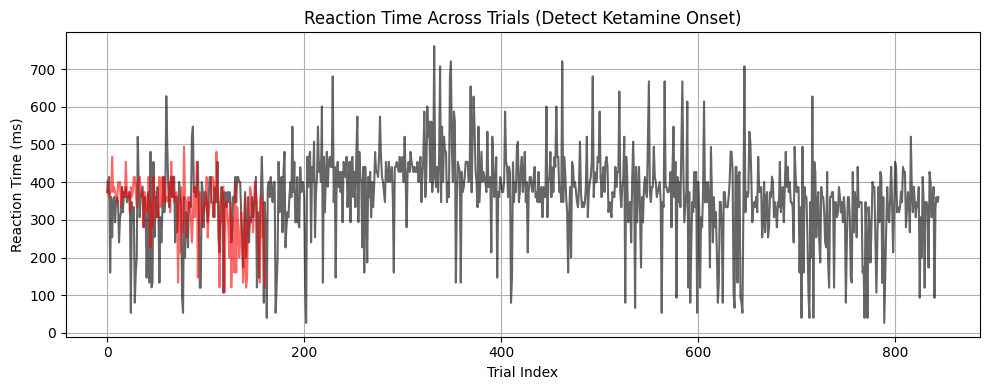

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(df.index, df["reaction_time"] * 1000, linestyle='-', color='black', alpha=0.6)
plt.plot(df_n.index, df_n["reaction_time"] * 1000, linestyle='-', color='red', alpha=0.6)
plt.xlabel("Trial Index")
plt.ylabel("Reaction Time (ms)")
plt.title("Reaction Time Across Trials (Detect Ketamine Onset)")
plt.grid(True)
plt.tight_layout()
plt.show()

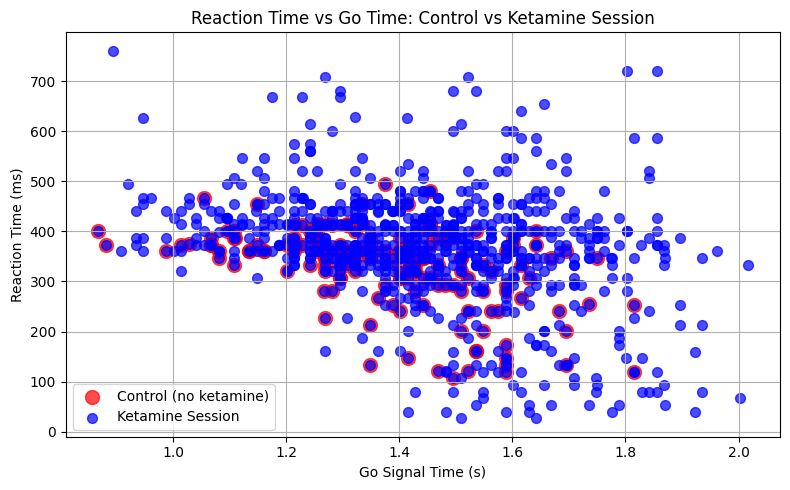

In [13]:
plt.figure(figsize=(8, 5))
plt.scatter(df_n["go_time"], df_n["reaction_time"] * 1000,
            color="red", alpha=0.7, label="Control (no ketamine)", s=100)

plt.scatter(df["go_time"], df["reaction_time"] * 1000,
            color="blue", alpha=0.7, label="Ketamine Session", s=50)

plt.xlabel("Go Signal Time (s)")
plt.ylabel("Reaction Time (ms)")
plt.title("Reaction Time vs Go Time: Control vs Ketamine Session")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

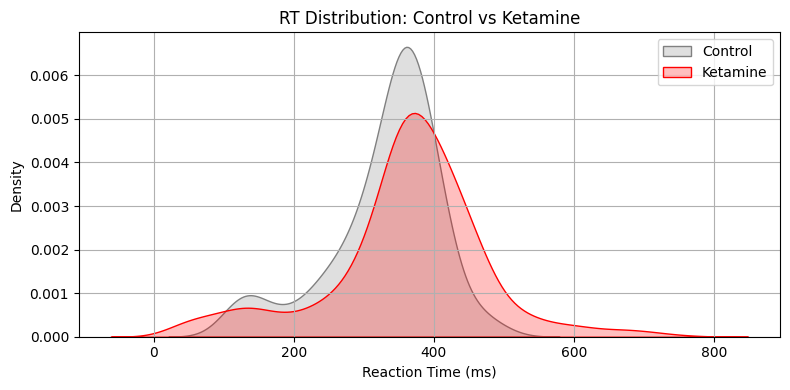

In [14]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df_n["reaction_time"] * 1000,
            label="Control", fill=True, color="gray")
sns.kdeplot(df["reaction_time"] * 1000,
            label="Ketamine", fill=True, color="red")
plt.xlabel("Reaction Time (ms)")
plt.title("RT Distribution: Control vs Ketamine")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(
    df_n["reaction_time"], df["reaction_time"], equal_var=False)
print(f"T-test: t = {t_stat:.2f}, p = {p_val:.3e}")

T-test: t = -4.25, p = 2.853e-05


In [16]:
df["reaction_time_ms"] = df["reaction_time"] * 1000
df["rolling_rt"] = df["reaction_time_ms"].rolling(
    window=15, center=True).mean()

In [17]:
df_n["reaction_time_ms"] = df_n["reaction_time"] * 1000
df_n["rolling_rt"] = df_n["reaction_time_ms"].rolling(
    window=15, center=True).mean()

In [18]:
df.reset_index(drop=True, inplace=True)

In [19]:
df_n.shape, df.shape

((161, 46), (845, 46))

In [20]:
df_n.sort_values("go_time", inplace=True)
df.sort_values("go_time", inplace=True)
df_n.reset_index(drop=True, inplace=True)

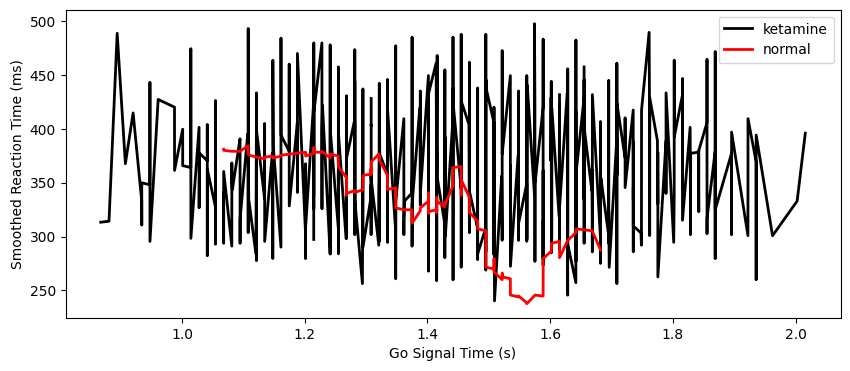

In [21]:
plt.figure(figsize=(10, 4))

plt.plot(df.go_time, df["rolling_rt"],
         color='black', linewidth=2, label="ketamine")

plt.plot(df_n.go_time, df_n["rolling_rt"],
         color='red', linewidth=2, label="normal")
plt.xlabel("Go Signal Time (s)")
plt.ylabel("Smoothed Reaction Time (ms)")
plt.legend()

<Axes: xlabel='go_time', ylabel='Density'>

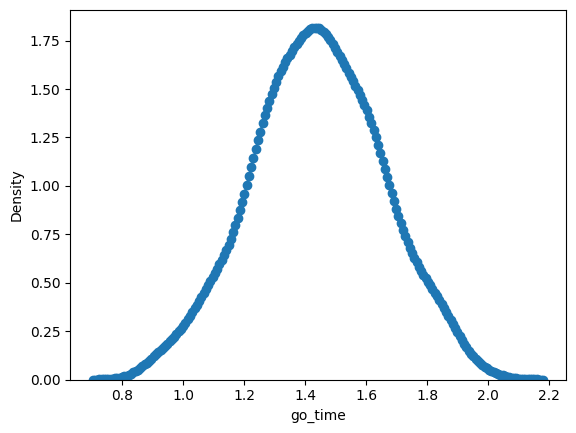

In [22]:
sns.kdeplot(df["go_time"], label="Go Time Distribution",marker = 'o')

<Axes: xlabel='go_time', ylabel='Density'>

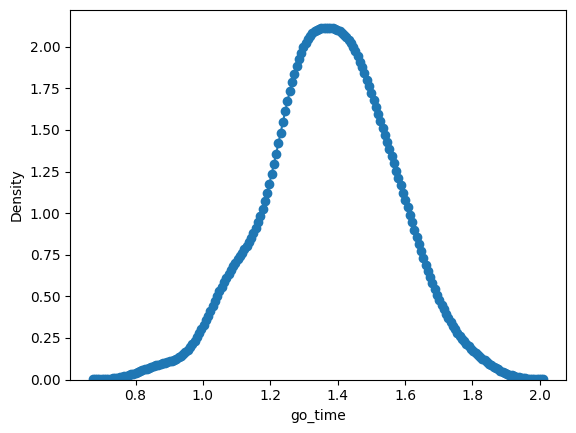

In [23]:
sns.kdeplot(df_n["go_time"], label="Go Time Distribution", marker = 'o')

In [28]:
mean_df = df["go_time"].mean()
std_df = df["go_time"].std()
mode_df = df["go_time"].mode()[0]

mean_df_n = df_n["go_time"].mean()
std_df_n = df_n["go_time"].std()
mode_df_n = df_n["go_time"].mode()[0]
print(f"Ketamine Session: Mean = {mean_df:.3f}, Std = {std_df:.3f}, Mode = {mode_df:.3f}")

print(f"Control Session: Mean = {mean_df_n:.3f}, Std = {std_df_n:.3f}")

t_stat, p_val = ttest_ind(
    df["go_time"], df_n["go_time"], equal_var=False)
print(f"T-test: t = {t_stat:.3f}, p = {p_val:.3e}")

Ketamine Session: Mean = 1.439, Std = 0.212, Mode = 1.335
Control Session: Mean = 1.376, Std = 0.180
T-test: t = 3.924, p = 1.121e-04


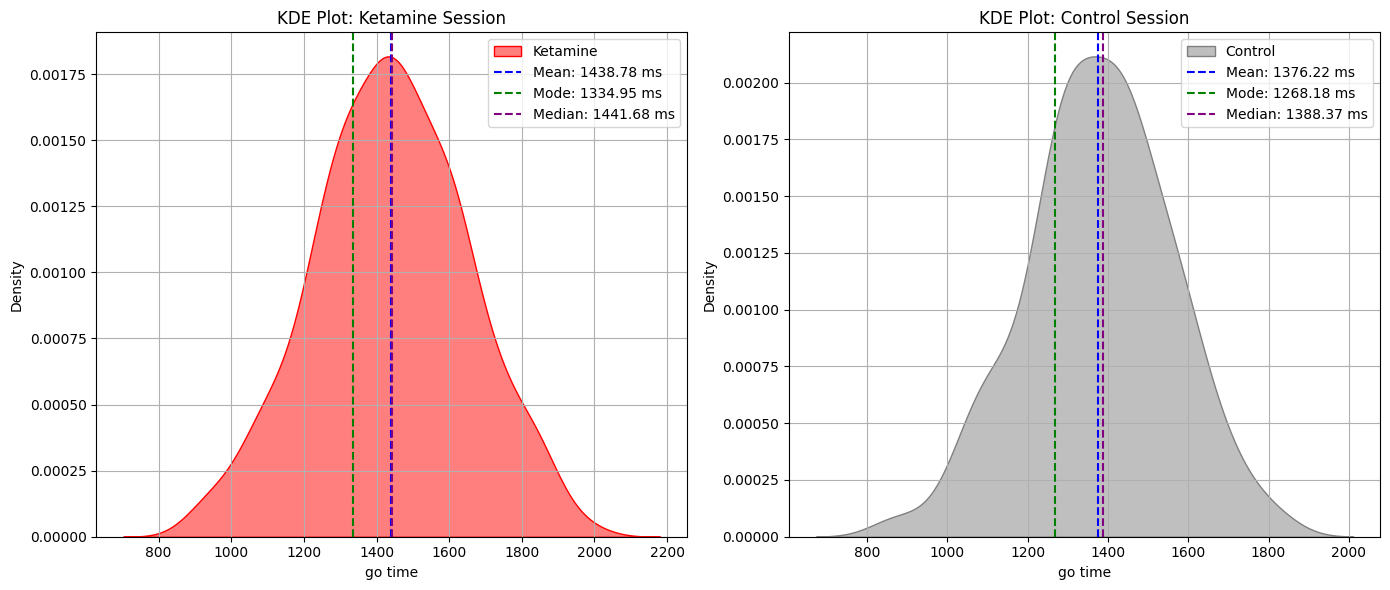

In [29]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(df["go_time"] * 1000, label="Ketamine",
            fill=True, color="red", alpha=0.5)
plt.axvline(mean_df * 1000, color="blue", linestyle="--",
            label=f"Mean: {mean_df * 1000:.2f} ms")
plt.axvline(mode_df * 1000, color="green", linestyle="--",
            label=f"Mode: {mode_df * 1000:.2f} ms")
plt.axvline(df["go_time"].median() * 1000, color="purple", linestyle="--",
            label=f"Median: {df['go_time'].median() * 1000:.2f} ms")
plt.xlabel("go time")
plt.ylabel("Density")
plt.title("KDE Plot: Ketamine Session")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
sns.kdeplot(df_n["go_time"] * 1000, label="Control",
            fill=True, color="gray", alpha=0.5)
plt.axvline(mean_df_n * 1000, color="blue", linestyle="--",
            label=f"Mean: {mean_df_n * 1000:.2f} ms")
plt.axvline(mode_df_n * 1000, color="green", linestyle="--",
            label=f"Mode: {mode_df_n * 1000:.2f} ms")
plt.axvline(df_n["go_time"].median() * 1000, color="purple", linestyle="--",
            label=f"Median: {df_n['go_time'].median() * 1000:.2f} ms")
plt.xlabel("go time")
plt.ylabel("Density")
plt.title("KDE Plot: Control Session")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [31]:
from scipy.stats import weibull_min, norm
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
import numpy as np

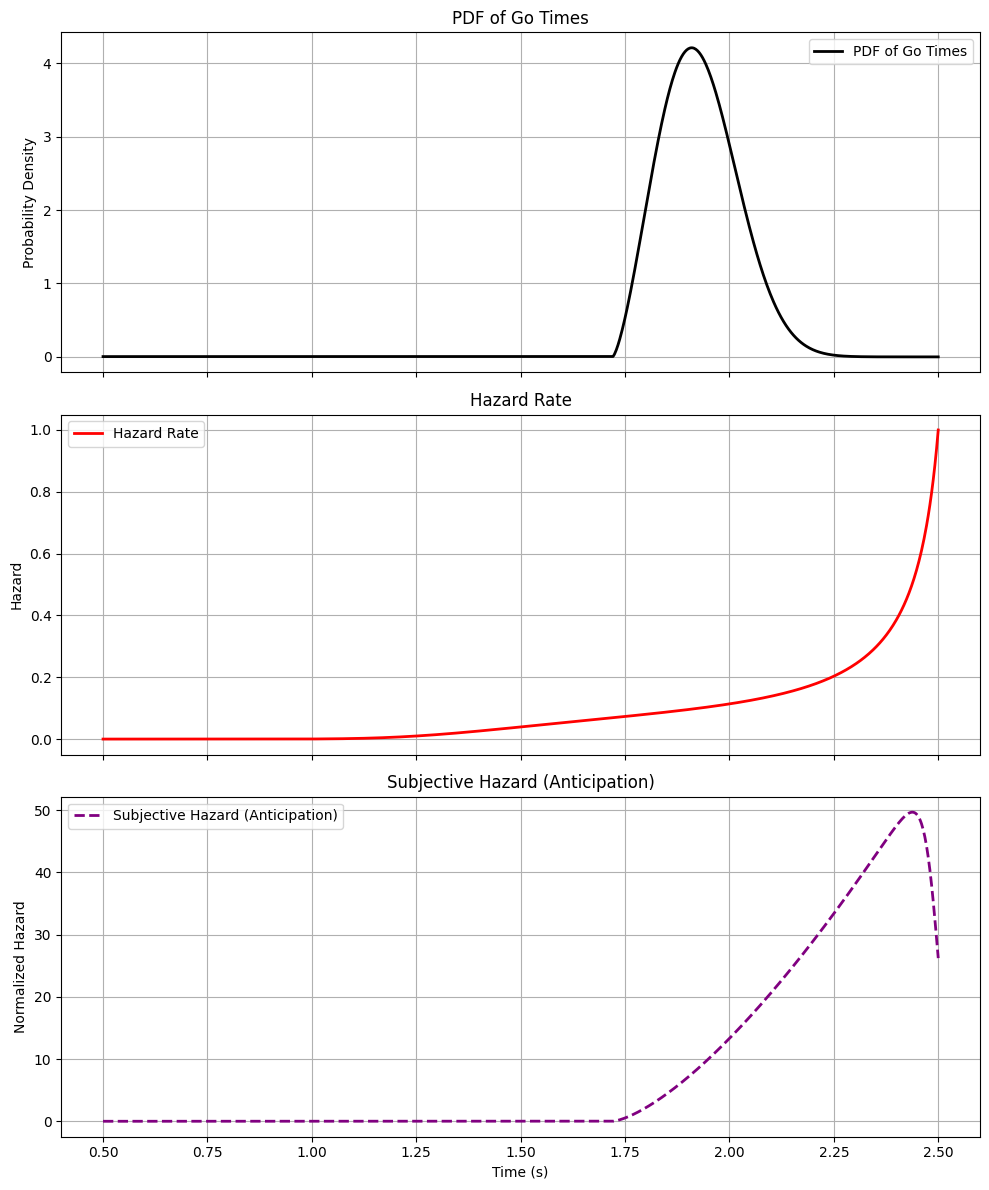

In [34]:
alpha = 4.25    
beta = 2.44    
delay = 1.72    
phi = 0.26     

t = np.linspace(0.5, 2.5, 1000)
t_adj = np.clip(t - delay, 1e-3, None)

pdf = weibull_min.pdf(t_adj, beta, scale=1 / alpha)

cdf = weibull_min.cdf(t_adj, beta, scale=1 / alpha)
subjective_hazard = pdf / (1 - cdf + 1e-8)

blurred = np.zeros_like(t)
for i, ti in enumerate(t):
    sigma = phi * ti
    kernel = norm.pdf(ti - t, scale=sigma)
    kernel /= kernel.sum()
    blurred[i] = np.sum(pdf * kernel)

F_blurred = np.cumsum(blurred) * (t[1] - t[0])
hazard = blurred / (1 - F_blurred + 1e-8)
hazard /= np.max(hazard)  

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

axs[0].plot(t, pdf, label="PDF of Go Times", color="black", lw=2)
axs[0].set_title("PDF of Go Times")
axs[0].set_ylabel("Probability Density")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(t, hazard, label="Hazard Rate", color="red", lw=2)
axs[1].set_title("Hazard Rate")
axs[1].set_ylabel("Hazard")
axs[1].grid(True)
axs[1].legend()

axs[2].plot(t, subjective_hazard, label="Subjective Hazard (Anticipation)", color="purple", lw=2, linestyle="--")
axs[2].set_title("Subjective Hazard (Anticipation)")
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Normalized Hazard")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

In [23]:
def blurred_weibull_hazard(t_array, alpha, beta, delay, phi=0.26):
    t_eval = np.linspace(0.5, 2.0, 1000)
    t_adj = np.clip(t_eval - delay, 1e-3, None)
    f = weibull_min.pdf(t_adj, beta, scale=1 / alpha)

    blurred = np.zeros_like(t_eval)
    for i, t in enumerate(t_eval):
        sigma = phi * t
        kernel = norm.pdf(t - t_eval, scale=sigma)
        kernel /= kernel.sum()
        blurred[i] = np.sum(f * kernel)

    F_blurred = np.cumsum(blurred) * (t_eval[1] - t_eval[0])
    hazard = blurred / (1 - F_blurred + 1e-8)
    return np.interp(t_array, t_eval, hazard / np.max(hazard))  

In [24]:
def rt_model(t, baseline, weight, alpha, beta, delay):
    h = blurred_weibull_hazard(t, alpha, beta, delay)
    return baseline - weight * h

In [25]:
def plot_fit(df_input, title, ax):
    df_input = df_input.copy()
    df_input["reaction_time"] = df_input["time_targ_acq"] - \
        df_input["time_FP_off"]
    df_input["go_time"] = df_input["time_FP_off"] - df_input["time_target_on"]
    df_input = df_input[df_input["reaction_time"].notna() &
                        df_input["go_time"].notna()].copy()
    df_input["reaction_time_ms"] = df_input["reaction_time"] * 1000
    df_input.sort_values("go_time", inplace=True)

    x = df_input["go_time"].values
    y = df_input["reaction_time_ms"].values
    p0 = [300, 100, 1.0, 3.0, 0.5]
    popt, _ = curve_fit(rt_model, x, y, p0=p0, maxfev=20000)

    x_fit = np.linspace(x.min(), x.max(), 300)
    y_fit = rt_model(x_fit, *popt)
    smoothed_rt = gaussian_filter1d(y, sigma=1)
    ax.plot(x, smoothed_rt, color='purple', lw=2.5, label="Smoothed RT")
    ax.plot(x_fit, y_fit, color='black', lw=2, label="Model Fit")
    anticipation = blurred_weibull_hazard(x_fit, *popt[2:])
    anticipation_scaled = anticipation * max(y) * 0.8
    ax.plot(x_fit, anticipation_scaled, '--', color='purple',
            lw=2, label="Anticipation Function")

    ax.set_title(title)
    ax.set_xlabel("Go Time (s)")
    ax.set_ylabel("Reaction Time (ms)")
    ax.grid(True)
    ax.legend(frameon=False)

    return popt

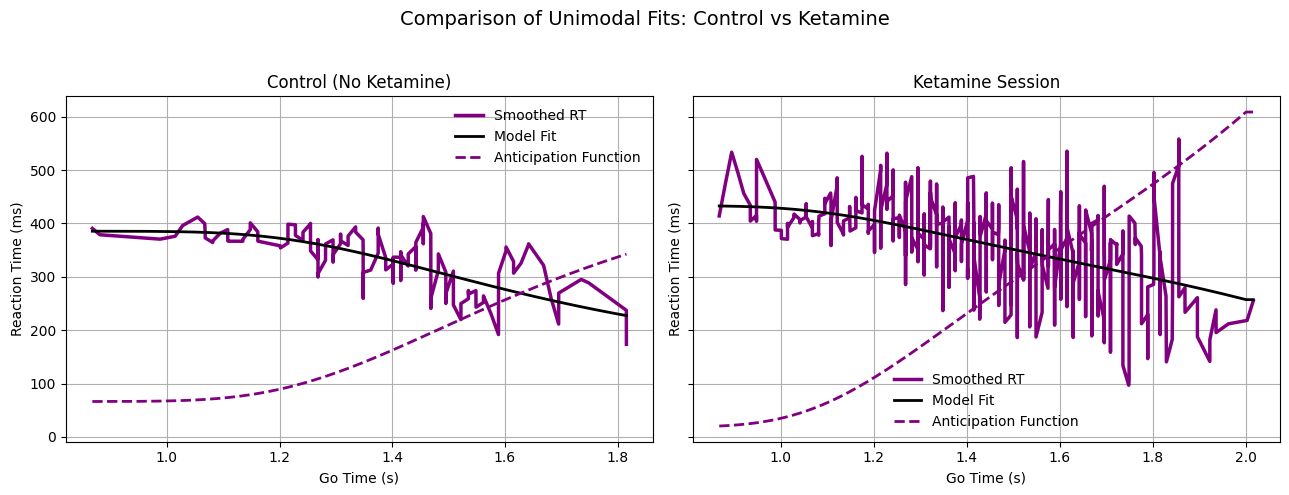

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

popt_control = plot_fit(df_n.copy(), "Control (No Ketamine)", axs[0])
popt_ketamine = plot_fit(df.copy(), "Ketamine Session", axs[1])

plt.suptitle("Comparison of Unimodal Fits: Control vs Ketamine", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [27]:
smoothed_rt = gaussian_filter1d(df["reaction_time_ms"], sigma=5)

In [28]:
delta_rt = np.gradient(smoothed_rt)
onset_idx = np.argmax(delta_rt)  
wear_off_idx = np.argmin(delta_rt[onset_idx+10:]) + onset_idx + 10
onset_go = df.loc[onset_idx, "go_time"]
wear_off_go = df.loc[wear_off_idx, "go_time"]

print(f"Estimated Ketamine ONSET at go_time = {onset_go:.2f}s")
print(f"Estimated Ketamine WEAR-OFF at go_time = {wear_off_go:.2f}s")

Estimated Ketamine ONSET at go_time = 1.43s
Estimated Ketamine WEAR-OFF at go_time = 1.66s


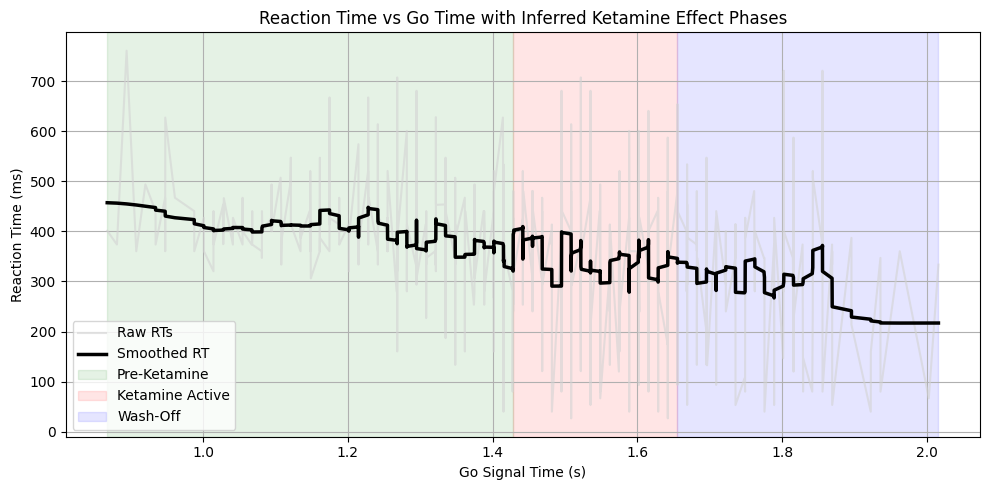

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(df["go_time"], df["reaction_time_ms"],
         color='lightgray', label="Raw RTs", alpha=0.6)
plt.plot(df["go_time"], smoothed_rt,
         color='black', lw=2.5, label="Smoothed RT")

plt.axvspan(df["go_time"].min(), onset_go,
            color='green', alpha=0.1, label="Pre-Ketamine")
plt.axvspan(onset_go, wear_off_go, color='red',
            alpha=0.1, label="Ketamine Active")
plt.axvspan(wear_off_go, df["go_time"].max(),
            color='blue', alpha=0.1, label="Wash-Off")

plt.xlabel("Go Signal Time (s)")
plt.ylabel("Reaction Time (ms)")
plt.title("Reaction Time vs Go Time with Inferred Ketamine Effect Phases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
rt_control_smooth = gaussian_filter1d(df_n["reaction_time_ms"], sigma=5)
rt_ket_smooth = gaussian_filter1d(df["reaction_time_ms"], sigma=5)

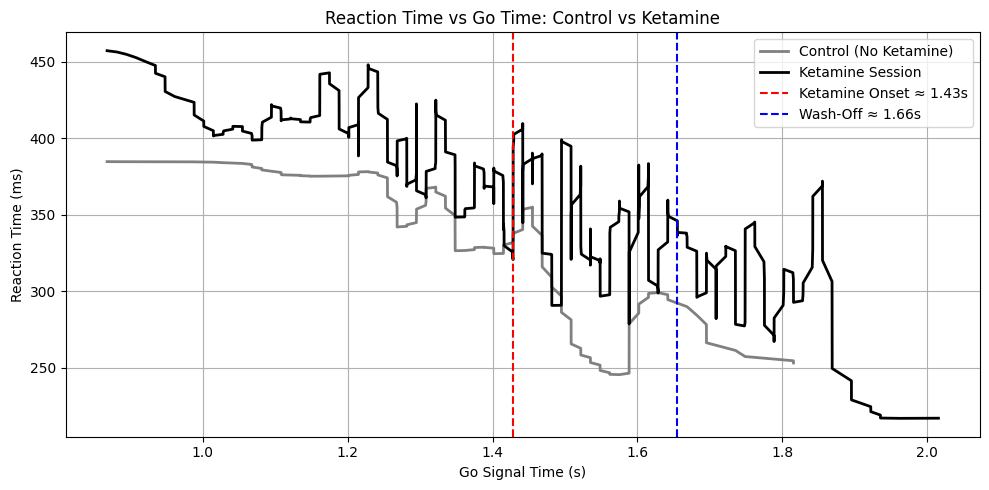

In [31]:
plt.figure(figsize=(10, 5))

plt.plot(df_n["go_time"], rt_control_smooth,
         color="gray", lw=2, label="Control (No Ketamine)")
plt.plot(df["go_time"], rt_ket_smooth,
         color="black", lw=2, label="Ketamine Session")

plt.axvline(onset_go, color="red", linestyle="--",
            label=f"Ketamine Onset ≈ {onset_go:.2f}s")
plt.axvline(wear_off_go, color="blue", linestyle="--",
            label=f"Wash-Off ≈ {wear_off_go:.2f}s")

plt.xlabel("Go Signal Time (s)")
plt.ylabel("Reaction Time (ms)")
plt.title("Reaction Time vs Go Time: Control vs Ketamine")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
df['go_time'].max(), df_n['go_time'].max()

(2.0157500000000255, 1.8156000000000176)

In [ ]:
df["elapsed_time"] = df["time_target_on"] - df["time_target_on"].min() 
df["phase"] = "pre"
df.loc[(df["elapsed_time"] >= 1200) & (
    df["elapsed_time"] <= 3000), "phase"] = "during"
df.loc[df["elapsed_time"] > 3000, "phase"] = "post"

In [35]:
df["reaction_time"] = df["time_targ_acq"] - df["time_FP_off"]
df["go_time"] = df["time_FP_off"] - df["time_target_on"]
df_clean = df[df["reaction_time"].notna() & df["go_time"].notna()].copy()

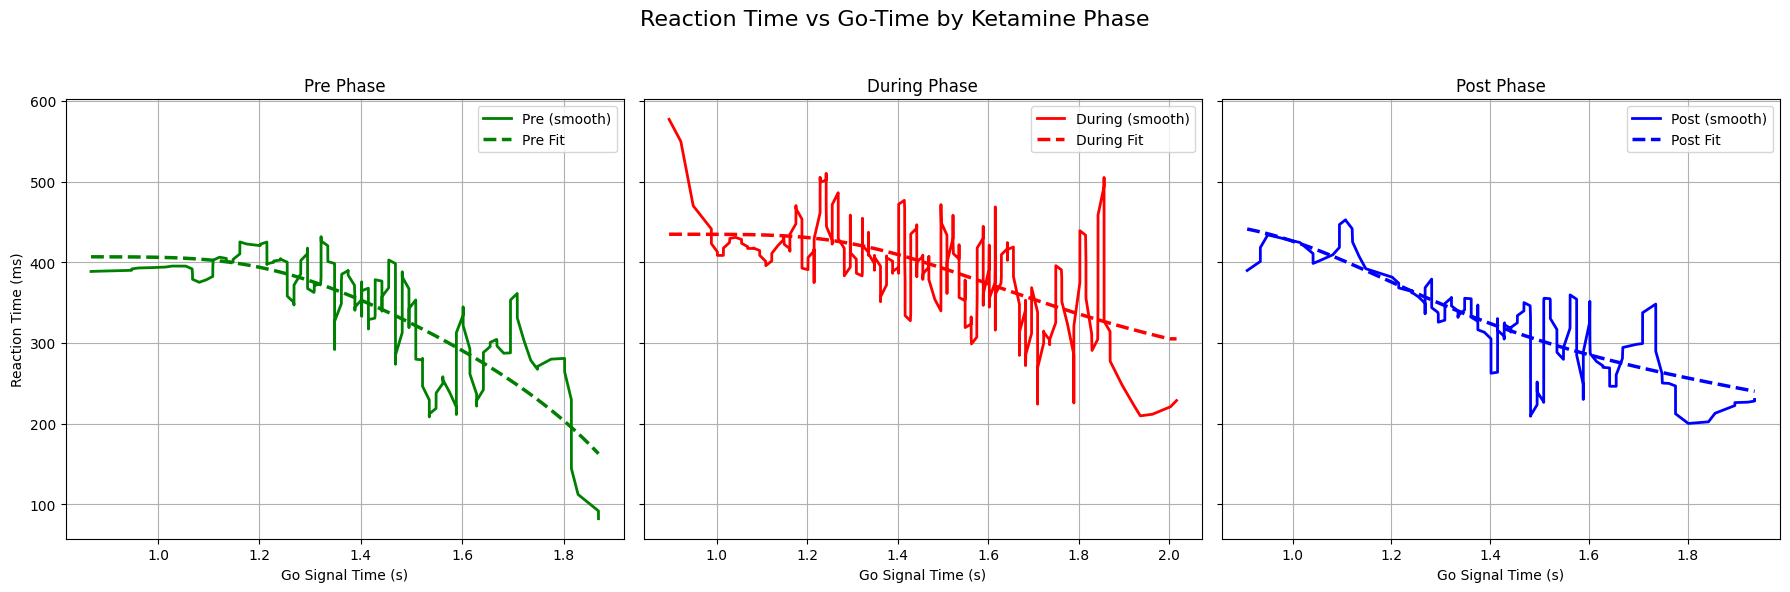

In [40]:
phase_colors = {"pre": "green", "during": "red", "post": "blue"}
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, phase in enumerate(["pre", "during", "post"]):
    ax = axs[i]
    df_phase = df_clean[df_clean["phase"] == phase].copy()
    x = df_phase["go_time"].values
    y = df_phase["reaction_time"].values * 1000
    if len(y) > 10:
        x_sorted_idx = np.argsort(x)
        y_smoothed = gaussian_filter1d(y[x_sorted_idx], sigma=2)
        ax.plot(x[x_sorted_idx], y_smoothed, lw=2,
                color=phase_colors[phase], label=f"{phase.title()} (smooth)")
        try:
            popt, _ = curve_fit(rt_model, x, y, p0=[
                                300, 100, 1.0, 3.0, 0.5], maxfev=10000)
            x_fit = np.linspace(x.min(), x.max(), 300)
            y_fit = rt_model(x_fit, *popt)
            ax.plot(x_fit, y_fit, lw=2.5,
                    color=phase_colors[phase], linestyle="--", label=f"{phase.title()} Fit")
        except:
            print(f"Could not fit model for phase: {phase}")
    ax.set_title(f"{phase.title()} Phase")
    ax.set_xlabel("Go Signal Time (s)")
    ax.grid(True)
    ax.legend()

axs[0].set_ylabel("Reaction Time (ms)")
fig.suptitle("Reaction Time vs Go-Time by Ketamine Phase", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [42]:
phase_params = {}

print("Model Parameters by Phase (Reaction Time = baseline - weight × anticipation(hazard))")
print("=" * 70)
print(f"{'Phase':<10}{'Baseline (ms)':<15}{'Weight':<10}{'Alpha':<10}{'Beta':<10}{'Delay (s)':<10}")
print("-" * 70)

for phase in ["pre", "during", "post"]:
    df_phase = df_clean[df_clean["phase"] == phase].copy()
    x = df_phase["go_time"].values
    y = df_phase["reaction_time"].values * 1000 

    try:
        popt, _ = curve_fit(rt_model, x, y, p0=[
                            300, 100, 1.0, 3.0, 0.5], maxfev=20000)
        phase_params[phase] = popt
        print(
            f"{phase:<10}{popt[0]:<15.2f}{popt[1]:<10.2f}{popt[2]:<10.2f}{popt[3]:<10.2f}{popt[4]:<10.2f}")
    except Exception as e:
        print(f"{phase:<10} Model fit failed: {e}")

Model Parameters by Phase (Reaction Time = baseline - weight × anticipation(hazard))
Phase     Baseline (ms)  Weight    Alpha     Beta      Delay (s) 
----------------------------------------------------------------------
pre       407.34         359.37    4.25      2.44      1.72      
during    434.74         129.68    0.37      27.41     2.00      
post      583.03         350.17    0.26      1.17      1.26      


Pre-Ketamine phase:
- Motor response is relatively fast (Baseline)
- Strong sensitivity to anticipation (Weight)
- Fairly sharp unimodal hazard function (Alpha and Beta)
- Relatively late subjective anticipation onset (Delay)

During-Ketamine phase:
- Motor response is slower 
- Impaired sensitivity to temporal hazard
- Hazard function becomes extremely unstable (decreased alpha and increased beta)
- Anticipation starts even later

Post-Ketamine phase:
- Lingering motor delay
- Anticipation sensitivity recovers
- Anticipation becomes unstable (noisier)
- Anticipation starts earlier again


| Effect | Model Signature | 
| ------- | ------ |
| Impaired anticipation | Weight decreases sharply during ketamine |
| Temporal uncertainty | Alpha decreases, Delay increases during ketamine |
| Motor slowing | Baseline RT increases during and especially post |
| Recovery | Weight & Delay return toward pre values |